### Housing DataSet Cleaning

Benny Cohen

12/1/2019

#### Introduction

The Housing Maintenance Code Violations found at https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5 describes several housing violations found in NY and provides details including where the incident was, (broken down by boro, and address), how severe it was (broken down into 3 classes, A,B,C where A is least severe and C the most severe)

In this notebook we will clean the data:
We need to...

1. Filter for the rows we need
2. Delete duplicate rows
3. Change datatypes,
4. Deal with missing data 

We then save the file to a csv for analysis




#### Initial Setup, Thoughts about Our Data, and Feature Selection

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Here we use the Socrata API to pull 50000 rows of data with the limit parameter. 

In [3]:
df = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$limit=50000")

Now let's see what the data looks like

In [4]:
rows, columns = df.shape
print('There are {:d} rows and {:d} columns '.format(rows,columns))

There are 50000 rows and 40 columns 


In [5]:
pd.set_option('display.max_columns', 50)
df.head()

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
0,10000009,265980,301467,3,BROOKLYN,355,355,355,EAST 48 STREET,36930,11203.0,NaN,2,4674,64,B,2013-10-08T00:00:00.000,2013-10-09T00:00:00.000,2013-11-28T00:00:00.000,2013-11-14T00:00:00.000,NaN,NaN,NaN,508,4705852,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-10T00:00:00.000,19,VIOLATION CLOSED,2015-03-31T00:00:00.000,Original,Close,40.653217,-73.932480,17.0,41.0,870.0,3102071.0,3.046740e+09,East Flatbush-Farragut
1,10000011,73852,226626,2,BRONX,1123,1123,1123,EAST TREMONT AVENUE,29620,10460.0,NaN,NaN,4004,9,B,2013-10-09T00:00:00.000,2013-10-15T00:00:00.000,2013-12-04T00:00:00.000,2013-11-20T00:00:00.000,NaN,NaN,NaN,686,4708486,SECTION 27-2040 ADM CODE PROVIDE ADEQUATE LIG...,2013-10-16T00:00:00.000,19,VIOLATION CLOSED,2015-09-15T00:00:00.000,Original,Close,40.839954,-73.876599,6.0,15.0,220.0,2042428.0,2.040040e+09,East Tremont
2,10000012,80102,211704,2,BRONX,751,751,751,GERARD AVENUE,35020,10451.0,3L,3,2482,30,B,2013-10-08T00:00:00.000,2013-10-10T00:00:00.000,2013-11-29T00:00:00.000,2013-11-15T00:00:00.000,NaN,NaN,NaN,501,4706454,SECTION 27-2005 ADM CODE PROPERLY REPAIR THE ...,2013-10-11T00:00:00.000,19,VIOLATION CLOSED,2014-10-17T00:00:00.000,Original,Close,40.824692,-73.926605,4.0,8.0,63.0,2002971.0,2.024820e+09,West Concourse
3,10000014,268639,350942,3,BROOKLYN,54,54,54,EAST 52 STREET,37080,11203.0,NaN,Yards / Courts,4605,19,B,2013-10-09T00:00:00.000,2013-10-10T00:00:00.000,2013-11-29T00:00:00.000,2013-11-15T00:00:00.000,NaN,NaN,NaN,686,4706684,SECTION 27-2040 ADM CODE PROVIDE ADEQUATE LIG...,2013-10-11T00:00:00.000,19,VIOLATION CLOSED,2016-08-16T00:00:00.000,Original,Close,40.659731,-73.929295,17.0,41.0,878.0,3099672.0,3.046050e+09,Prospect Lefferts Gardens-Wingate
4,10000017,268167,300713,3,BROOKLYN,146,146,146,EAST 52 STREET,37080,11203.0,NaN,Yards / Courts,4621,21,B,2013-10-09T00:00:00.000,2013-10-10T00:00:00.000,2013-11-29T00:00:00.000,2013-11-15T00:00:00.000,NaN,NaN,NaN,686,4706680,SECTION 27-2040 ADM CODE PROVIDE ADEQUATE LIG...,2013-10-11T00:00:00.000,19,VIOLATION CLOSED,2014-09-30T00:00:00.000,Original,Close,40.657615,-73.929067,17.0,41.0,878.0,3100214.0,3.046210e+09,Prospect Lefferts Gardens-Wingate


We see several noteworthy columns that we want to keep. Let's filter for them now to make the rest of our analysis easier. 

1. `violationid` - unique identifier for incident. 
    A.In order to use this field we need to validate that...    
        a.Each id truly is unique
        b.There is only one id per incident
        
2. `buildingid` - unique identifier for building

    A. We can see from this whether there are buildings with multiple incidents
    
    
3. `boro` - This tells us which boro an incident took place in


4. `zip` - This tells us the zip code an incident took place in. 

    A. This field and borough will help us find geographic trends in incidents
    
    B. We can use the zip field to verify that the boro field is correct
    
    
5. `inspectiondate` - This tells us when an incident was opened.


6. `novdescription` - Describes the violation


7. `class` - Tells how severe a violation is. A is most severe, B is medium, and C is low. 


8. `currentstatus` - The current status of the inspection (ie - OPEN, CLOSED...)


9. `currentstatusdate` - The date when the status was updated to its current state


10. `newcorrectbydate` - The date for incidents which were postponed. 


11. `originalcorrectbydate` - The date for which incidents were originally set. 


Note that fields 10 and 11 we aren't actually using in the analysis. We need them though to see if a row is being repeated or updated. 

       
    

In [6]:
with open('..\config\columns.txt') as file:
    columns = [line.rstrip().rstrip('\n') for line in file]
filteredData = df[columns]

First let's use the info method to see the columns count and data types

In [7]:
filteredData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
violationid              50000 non-null int64
buildingid               50000 non-null int64
boro                     50000 non-null object
zip                      49998 non-null float64
inspectiondate           50000 non-null object
originalcorrectbydate    49347 non-null object
newcorrectbydate         495 non-null object
novdescription           50000 non-null object
class                    50000 non-null object
currentstatus            50000 non-null object
currentstatusdate        50000 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB


Let's make notes about things we need to correct. 

1. Missing data: We note that we had 50000 rows and see that since count ignores nulls that most of the columns contain all the info. Some don't though. `zip` is missing two rows. `newcorrectbydate` is missing many rows simply because there weren't that many postponments granted. We might want to filter these into their own file to look at later 

2. Datatypes: Date columns are going to need to be changed to datetime. We actually have no 'numeric' data because all of our numeric types are ids so there is no point in doing a df.describe to see numeric info.  

#### Verifying id 

In [8]:
filteredData.violationid.value_counts().sort_values(ascending = False).head()

10946561    1
10029153    1
11296559    1
10106887    1
10093767    1
Name: violationid, dtype: int64

We see that the highest cound for an id is 1, confirming that ids are unique. 

The harder thing to check is do incidents get repeated under multiple ids.... First let's see if we have any duplicate incidents since that's easy... There are 2 ways to do this. We can use the drop duplicates function or we can merge the dataframes on the unique attributes. The first is most definetly faster but the second let's us explore the data more...

In [9]:
joined = pd.merge(filteredData,filteredData, on = ['violationid'], how = 'inner')
joined.shape

(50000, 21)

So when we join on the id column we get all the rows as we expected... since that is unique as we already showed Now let's join without the id column. We should get the same output if there is no duplicate data. If there is duplicate data we are going to get extra rows since each row would map to a row on something more than itself.

In [10]:
joined = pd.merge(filteredData,filteredData, on = list(filteredData.columns)[1:], how = 'inner')


In [11]:
sameviolation = joined[joined['violationid_x'] != joined['violationid_y']]

In [12]:
sameviolation.shape

(124, 12)

So 124 rows seem to contain duplicate data... Maybe let's look at them

In [13]:
sameviolation

,violationid_x,buildingid,boro,zip,inspectiondate,originalcorrectbydate,newcorrectbydate,novdescription,class,currentstatus,currentstatusdate,violationid_y
591,10002024,122711,BRONX,10472.0,2013-10-09T00:00:00.000,2013-10-19T00:00:00.000,NaN,"SECTION 27-2005, 2007 ADM CODE REMOVE THE ILL...",C,VIOLATION CLOSED,2016-05-17T00:00:00.000,10002045
592,10002045,122711,BRONX,10472.0,2013-10-09T00:00:00.000,2013-10-19T00:00:00.000,NaN,"SECTION 27-2005, 2007 ADM CODE REMOVE THE ILL...",C,VIOLATION CLOSED,2016-05-17T00:00:00.000,10002024
1688,10005692,42588,MANHATTAN,10031.0,2013-10-11T00:00:00.000,2013-11-21T00:00:00.000,NaN,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,B,VIOLATION CLOSED,2015-06-17T00:00:00.000,10005758
1689,10005758,42588,MANHATTAN,10031.0,2013-10-11T00:00:00.000,2013-11-21T00:00:00.000,NaN,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,B,VIOLATION CLOSED,2015-06-17T00:00:00.000,10005692
2194,10007391,67195,BRONX,10458.0,2013-10-16T00:00:00.000,2013-11-25T00:00:00.000,NaN,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,B,VIOLATION CLOSED,2015-03-17T00:00:00.000,10007409
2195,10007409,67195,BRONX,10458.0,2013-10-16T00:00:00.000,2013-11-25T00:00:00.000,NaN,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,B,VIOLATION CLOSED,2015-03-17T00:00:00.000,10007391
2737,10009095,683226,QUEENS,11691.0,2013-10-16T00:00:00.000,2013-11-25T00:00:00.000,NaN,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,B,VIOLATION CLOSED,2014-09-23T00:00:00.000,10009130
2738,10009130,683226,QUEENS,11691.0,2013-10-16T00:00:00.000,2013-11-25T00:00:00.000,NaN,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,B,VIOLATION CLOSED,2014-09-23T00:00:00.000,10009095
3025,10409069,27624,MANHATTAN,10040.0,2014-10-06T00:00:00.000,2015-01-11T00:00:00.000,NaN,SECTION 27-2005 ADM CODE PROPERLY REPAIR WITH...,A,VIOLATION CLOSED,2018-10-07T00:00:00.000,10409093
3026,10409093,27624,MANHATTAN,10040.0,2014-10-06T00:00:00.000,2015-01-11T00:00:00.000,NaN,SECTION 27-2005 ADM CODE PROPERLY REPAIR WITH...,A,VIOLATION CLOSED,2018-10-07T00:00:00.000,10409069


In [14]:
#One sample row
df[df['violationid'] == 10005692]

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
1685,10005692,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights


In [15]:
df[df['violationid'] == 10005758]

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
1708,10005758,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights


Are these really duplicates? Maybe something is unique about them? Maybe there is a field missing from the data? Maybe it's a collection problem?

Text(0.5, 1.0, 'Incidents per boro')

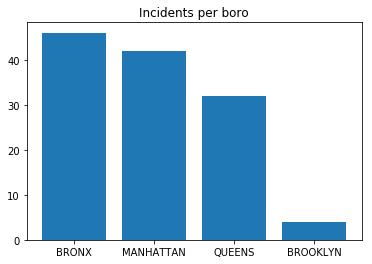

In [16]:
plt.bar(sameviolation['boro'].unique(), sameviolation['boro'].value_counts())
plt.title("Incidents per boro")

It's unclear, but we can drop them since we have enough data anyways...

In [17]:
filteredData = filteredData.set_index('violationid').sort_index() #might as well if we are treating these as ids....

In [18]:
filteredData = filteredData.drop(sameviolation.violationid_x)

In [19]:
filteredData.shape

(49876, 10)

Okay... Part 1 is done... now let's see if incidents are repeated... Let's show the alternate method...


In [20]:
filteredData.columns

Index(['buildingid', 'boro', 'zip', 'inspectiondate', 'originalcorrectbydate',
       'newcorrectbydate', 'novdescription', 'class', 'currentstatus',
       'currentstatusdate'],
      dtype='object')

In [22]:
filteredData.duplicated(subset = ['buildingid', 'boro', 'zip', 'inspectiondate',
       'originalcorrectbydate', 'novdescription', 'class',
       ]).any()

True

So there are duplicates... Now let's find them to see what they look like

In [24]:
dups = filteredData[filteredData.duplicated(subset = ['buildingid', 'boro', 'zip', 'inspectiondate',
       'originalcorrectbydate', 'novdescription', 'class',
       ], keep = False)]
dups.head(2)

,buildingid,boro,zip,inspectiondate,originalcorrectbydate,newcorrectbydate,novdescription,class,currentstatus,currentstatusdate
violationid,,,,,,,,,,
10077942,27167,MANHATTAN,10002.0,2013-12-26T00:00:00.000,2016-10-26T00:00:00.000,NaN,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,B,VIOLATION DISMISSED,2016-11-09T00:00:00.000
10077946,27167,MANHATTAN,10002.0,2013-12-26T00:00:00.000,2016-10-26T00:00:00.000,NaN,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,B,NOT COMPLIED WITH,2016-11-09T00:00:00.000


This isn't really what we were expecting to see. We see the same violation listed 2x with different statuses. It could also just be that these were seperate violations just given the same nov description. 


We are in good 'shape' (pun intended) though because few such rows exist. 

There may in fact be multiple entries for the same incident but because we are taking a small subset of the data we don't have to deal with this problem as we have just shown. Let's just get rid of them since there are only a few

In [25]:
filteredData = filteredData.drop(dups.index, axis = 0)

#### Correcting DataTypes

In [26]:
filteredData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49870 entries, 142202 to 13258012
Data columns (total 10 columns):
buildingid               49870 non-null int64
boro                     49870 non-null object
zip                      49868 non-null float64
inspectiondate           49870 non-null object
originalcorrectbydate    49217 non-null object
newcorrectbydate         493 non-null object
novdescription           49870 non-null object
class                    49870 non-null object
currentstatus            49870 non-null object
currentstatusdate        49870 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 4.2+ MB


All we need to do is convert the date columns to dates and zip to an int. The strings are encoded as categorical data properly. 

In [27]:
filteredData['currentstatusdate'] = pd.to_datetime(filteredData['currentstatusdate'])
filteredData['inspectiondate'] = pd.to_datetime(filteredData['inspectiondate'])
filteredData['originalcorrectbydate'] = pd.to_datetime(filteredData['originalcorrectbydate'])
filteredData['newcorrectbydate'] = pd.to_datetime(filteredData['newcorrectbydate'])
filteredData['currentstatusdate '] = pd.to_datetime(filteredData['currentstatusdate'])

In [28]:
filteredData.inspectiondate.dtype

dtype('<M8[ns]')

We see that they it is now a datetime (That is a datetime type). 
The last thing I want to adress are nulls. Let's see what columns have nulls

In [29]:
nulls = filteredData.isnull().any()
nulls

buildingid               False
boro                     False
zip                       True
inspectiondate           False
originalcorrectbydate     True
newcorrectbydate          True
novdescription           False
class                    False
currentstatus            False
currentstatusdate        False
currentstatusdate        False
dtype: bool

In [30]:
filteredData[filteredData['zip'].isnull()]

,buildingid,boro,zip,inspectiondate,originalcorrectbydate,newcorrectbydate,novdescription,class,currentstatus,currentstatusdate,currentstatusdate
violationid,,,,,,,,,,,
10030576,883013,BRONX,NaN,2013-11-01,2014-02-28,NaT,SECTION 27-2098 ADM CODE FILE WITH THIS DEPAR...,A,VIOLATION DISMISSED,2015-03-10,2015-03-10
12878430,855030,QUEENS,NaN,2019-01-28,2019-02-07,NaT,"SECTION 27-2026, 2027 HMC: PROPERLY REPAIR THE...",C,NOV SENT OUT,2019-01-30,2019-01-30


Zip looks like a data entry problem. We can leave it since the other data is usefull. The same is true of the originalcorrectbydate and newcorrectbydate fields. We simply can exclude them directly when we do the analysis. 
The newcorrectbydate is null when there are no postponments given to rectify the date. Those we can also leave since we are going to filter them to a file.



#### Write to a file

In [31]:
reopened = filteredData[~filteredData.newcorrectbydate.isnull()]
clean = filteredData[filteredData.newcorrectbydate.isnull()]

clean.to_csv("../data/clean.csv")
reopened.to_csv("../data/reopened.csv")

#### Disclaimer and Additional data needed

Recall above I used a generic url to pull data from Socrata. 
We shouldn't assume this but for arguments sake let's say that the data we are collecting is a random sample, meaning that it is equally likely to select any of the rows and they are not selected by some sorted indexed. This allows us to do most of our analysis. 

But...

By inspection which we will show in the following notebook this random sample assumption is definetly not true when it comes to at least `inspection date`. We don't want this data tainted so let's just take in all the rows by each year...

We use the Socrata SQL API toselect the rows of the respective year. For space and time reasons we are only going to be doing this when we study the when although it is possible our other results are tainted.

In [39]:
df_2017 = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$query=Select%20inspectiondate%20where%20inspectiondate%20between%20'2017-01-01T12:00:00'%20and%20'2017-12-31T23:59:00'%20limit%20900000", parse_dates = ['inspectiondate'])
df_2018 = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$query=Select%20inspectiondate%20where%20inspectiondate%20between%20'2018-01-01T12:00:00'%20and%20'2018-12-31T23:59:00'%20limit%20900000", parse_dates = ['inspectiondate'])
df_2016 = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$query=Select%20inspectiondate%20where%20inspectiondate%20between%20'2016-01-01T12:00:00'%20and%20'2016-12-31T23:59:00'%20limit%20900000", parse_dates = ['inspectiondate'])
df_2014 = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$query=Select%20inspectiondate%20where%20inspectiondate%20between%20'2014-01-01T12:00:00'%20and%20'2014-12-31T23:59:00'%20limit%20900000", parse_dates = ['inspectiondate'])

In [42]:
df_2017.to_csv("../data/inspection_2017.csv")
df_2018.to_csv("../data/inspection_2018.csv")
df_2016.to_csv("../data/inspection_2016.csv")
df_2014.to_csv("../data/inspection_2014.csv")
df_2017.head(3)

,inspectiondate
0,2017-01-02
1,2017-01-02
2,2017-01-02


We also are interested in creating a graph of where incidents occur by zip code. To do this we need a csv with the zip code of each borough, number of incidents in each, and latitude and longitude. First let's get the counts 

In [55]:
zipCodes = df['zip'].astype(np.str).str.extract('(.+?(?=\.))') #It adds a decimal since it was imported as float
counts = zipCodes[0].value_counts()
counts.head()

11226    1898
10453    1736
10458    1536
10457    1504
11221    1489
Name: 0, dtype: int64

And let's get the longitude and latitudes from opendatasoft (similar to socrata, this also has an api to get data)

In [56]:
import requests

response = requests.get('https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&rows=10000&facet=state&facet=timezone&facet=dst&refine.state=NY')
zipToLatitudeLongitudeMapper = response.json()

We won't actually print this yet since this is a very big JSON file. We have an array of records. Each record (ie zip code) is a hash, one of whose fields is ingeniously called 'fields' which is a hash contained the info we need...

In [57]:
len(zipToLatitudeLongitudeMapper['records'])

2281

We have 2281 zip codes in NY... Here's what one record looks like...

In [58]:
zipToLatitudeLongitudeMapper['records'][0]

{'datasetid': 'us-zip-code-latitude-and-longitude',
 'recordid': '6e589b15cb714258c5710936f33ed6100774d2c2',
 'fields': {'city': 'Henderson',
  'zip': '13650',
  'dst': 1,
  'geopoint': [43.82212, -76.2127],
  'longitude': -76.2127,
  'state': 'NY',
  'latitude': 43.82212,
  'timezone': -5},
 'geometry': {'type': 'Point', 'coordinates': [-76.2127, 43.82212]},
 'record_timestamp': '2018-02-09T16:33:38.603000+00:00'}

In [59]:
def getWantedInfo(record):
    return (record['fields']['city'],record['fields']['zip'],record['fields']['longitude'], record['fields']['latitude'] )

Let's use this function to get our data by mapping it through the json

In [60]:
zipToLatitudeLongitudeMapper = list(map(getWantedInfo, zipToLatitudeLongitudeMapper['records']))

In [61]:
zipToLatitudeLongitudeMapper[0:5]

[('Henderson', '13650', -76.2127, 43.82212),
 ('Buffalo', '14219', -78.82717, 42.790708),
 ('Pine Valley', '14872', -76.84694, 42.218224),
 ('New York', '10286', -74.011895, 40.714231),
 ('Albany', '12230', -73.970812, 42.614852)]

In [62]:
GeoCodeDf = pd.DataFrame(zipToLatitudeLongitudeMapper, columns = ['city','zip','lat','long'], dtype = np.str)
countsDf = pd.DataFrame(counts).reset_index()
countsDf.columns = ['zip','count']
GeoCodeDf.head()

,city,zip,lat,long
0,Henderson,13650,-76.2127,43.82212
1,Buffalo,14219,-78.82717,42.790708
2,Pine Valley,14872,-76.84694,42.218224
3,New York,10286,-74.011895,40.714231
4,Albany,12230,-73.970812,42.614852


Now let's merge the counts with the zip code

In [63]:
mergedDf = countsDf.merge(GeoCodeDf, on = 'zip')
mergedDf.head()

,zip,count,city,lat,long
0,11226,1898,Brooklyn,-73.95553,40.645256
1,10453,1736,Bronx,-73.91214,40.853017
2,10458,1536,Bronx,-73.88881,40.864166
3,10457,1504,Bronx,-73.89861,40.846745
4,11221,1489,Brooklyn,-73.92637,40.691234


Now let's save this...

In [64]:
mergedDf.to_csv('../data/zip_count.csv')